In [7]:
#インポート
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
import matplotlib.pyplot as plt
import datetime

In [83]:
import matplotlib.font_manager
matplotlib.font_manager.fontManager.addfont("/home/materialsinformatics/anaconda3/envs/py39torch/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams['figure.subplot.bottom'] = 0.2 # 見切れ防止
plt.rcParams['figure.subplot.left'] = 0.2 # 見切れ防止
plt.rcParams['font.family'] ='Arial'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18 #フォントの大きさ
plt.figure(figsize=(4,4))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [3]:
df = pd.read_csv("data/OPV_database_1295.csv")

In [4]:
import numpy as np
import pandas as pd
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw,  ReducedGraphs, MACCSkeys
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.EState import Fingerprinter
# from mordred import Calculator, descriptors

def smiles_to_avalon(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    fingerprint = pyAvalonTools.GetAvalonFP(molecule)
    return fingerprint

from rdkit.Chem import MACCSkeys

def smiles_to_maccskeys(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    maccs_keys = MACCSkeys.GenMACCSKeys(molecule)
    return maccs_keys.ToBitString()

from rdkit.Chem import AllChem,Descriptors

def smiles_to_ecfp(smiles, radius=2, nbits=1024):
    molecule = Chem.MolFromSmiles(smiles)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=nbits)
    return ecfp.ToBitString()

def smiles_to_estate(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    estate = Descriptors.EStateIndices(molecule)
    return estate

In [5]:
def Mol2Vec(smiles, fptype="ECFP", radius=2, bits = 1024):
    vector = np.zeros((1,))
    mol = Chem.MolFromSmiles(smiles)
    bitI_morgan = {}
    if fptype == "ECFP":
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, bits), vector)
    elif fptype == "Avalon":
        DataStructs.ConvertToNumpyArray(GetAvalonFP(mol), vector)
    elif fptype == "MACCSKeys":
        DataStructs.ConvertToNumpyArray(AllChem.GetMACCSKeysFingerprint(mol), vector)
    elif fptype == "ErG":
        vector = ReducedGraphs.GetErGFingerprint(mol)
    elif fptype == "Estate":
        vector = Fingerprinter.FingerprintMol(mol)[0]
    # elif fptype == "RDKit":
    #     vector = list(descriptor_calculation.CalcDescriptors(mol))
    #     for index, value in enumerate(vector):
    #         if index == 40: # IPC descriptor 
    #             vector[index] = Descriptors.Ipc(mol, avg=True)
    #     vector = np.array(vector)
    else:
        raise TypeError()
    return vector

In [14]:
# i = 100
n_ErG = []
p_ErG = []
n_Estate = []
p_Estate = []
n_MACCSKeys = []
p_MACCSKeys = []
n_ECFP = []
p_ECFP = []

t0 = time.time()
for i in range(len(df)):   
    n_ErG.append(Mol2Vec(smiles = df["n(SMILES)"][i], fptype="ErG"))
    p_ErG.append(Mol2Vec(smiles = df["p(SMILES)"][i], fptype="ErG"))
    n_Estate.append(Mol2Vec(smiles = df["n(SMILES)"][i], fptype="Estate"))
    p_Estate.append(Mol2Vec(smiles = df["p(SMILES)"][i], fptype="Estate"))
    n_MACCSKeys.append(Mol2Vec(smiles = df["n(SMILES)"][i], fptype="MACCSKeys"))
    p_MACCSKeys.append(Mol2Vec(smiles = df["p(SMILES)"][i], fptype="MACCSKeys"))
    n_ECFP.append(Mol2Vec(smiles = df["n(SMILES)"][i], fptype="ECFP"))
    p_ECFP.append(Mol2Vec(smiles = df["p(SMILES)"][i], fptype="ECFP"))
    if i % 100 == 0:
        t = time.time()
        print(i, t-t0)

0 0.03963422775268555
100 35.01548361778259
200 37.65438532829285
300 39.79473829269409
400 42.538994789123535
500 45.516457319259644
600 47.92937684059143
700 50.81099343299866
800 53.78161549568176
900 56.24646210670471
1000 665.6299073696136
1100 668.3694589138031
1200 671.7344422340393


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

In [15]:
X_ErG = np.concatenate([n_ErG, p_ErG], axis = 1)
X_ECFP = np.concatenate([n_ECFP, p_ECFP], axis = 1)
X_Estate = np.concatenate([n_Estate, p_Estate], axis = 1)
X_MACCSKeys = np.concatenate([n_MACCSKeys, p_MACCSKeys], axis = 1)

In [36]:
pd.DataFrame(X_ErG).to_csv("X_ErG.csv", index = False)
pd.DataFrame(X_ECFP).to_csv("X_ECFP.csv", index = False)
pd.DataFrame(X_Estate).to_csv("X_Estate.csv", index = False)
pd.DataFrame(X_MACCSKeys).to_csv("X_MACCSKeys.csv", index = False)

In [37]:
y = df["PCE_ave(%)"]

In [38]:
for disc in ["ErG", "ECFP", "Estate", "MACCSKeys"]:
    print("RF", disc)
    X = pd.read_csv(f"X_{disc}.csv")
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    pd.DataFrame(y_train_pred).to_csv(f"y_train_pred_RF_{disc}.csv", index = False)
    pd.DataFrame(y_test_pred).to_csv(f"y_test_pred_RF_{disc}.csv", index = False)
    print("R2_train",r2_score(y_train, y_train_pred))
    print("R2_test", r2_score(y_test, y_test_pred))

RF ErG
R2_train 0.8506941376487915
R2_test 0.6085849553524434
RF ECFP
R2_train 0.9391490951803427
R2_test 0.6460842177346606
RF Estate
R2_train 0.9231557143821958
R2_test 0.6855897755059253
RF MACCSKeys
R2_train 0.8261055552043035
R2_test 0.5729231677300817


In [43]:
for disc in ["ErG", "ECFP", "Estate", "MACCSKeys"]:
    print("GB", disc)
    X = pd.read_csv(f"X_{disc}.csv")
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    gb = GradientBoostingRegressor(n_estimators = 500)
    gb.fit(X_train, y_train)
    y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)
    pd.DataFrame(y_train_pred).to_csv(f"y_train_pred_GB_{disc}.csv", index = False)
    pd.DataFrame(y_test_pred).to_csv(f"y_test_pred_GB_{disc}.csv", index = False)
    print("R2_train",r2_score(y_train, y_train_pred))
    print("R2_test", r2_score(y_test, y_test_pred))

GB ErG
R2_train 0.8571469209561475
R2_test 0.588519007728465
GB ECFP
R2_train 0.8974919730672097
R2_test 0.6135868777546143
GB Estate
R2_train 0.8603864325917016
R2_test 0.6239042276401536
GB MACCSKeys
R2_train 0.7851253425826168
R2_test 0.5266766807155587


In [42]:
for disc in ["ErG", "ECFP", "Estate", "MACCSKeys"]:
    print("NN", disc)
    X = pd.read_csv(f"X_{disc}.csv")
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    nn = MLPRegressor(max_iter=500)
    nn.fit(X_train, y_train)
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    pd.DataFrame(y_train_pred).to_csv(f"y_train_pred_NN_{disc}.csv", index = False)
    pd.DataFrame(y_test_pred).to_csv(f"y_test_pred_NN_{disc}.csv", index = False)
    print("R2_train",r2_score(y_train, y_train_pred))
    print("R2_test", r2_score(y_test, y_test_pred))

NN ErG
R2_train 0.5778117061890415
R2_test 0.37740582458078853
NN ECFP
R2_train 0.9507429846441106
R2_test 0.5114575245093285
NN Estate
R2_train 0.7498464199637533
R2_test 0.5092635781934913
NN MACCSKeys
R2_train 0.7705084827718341
R2_test 0.5223710512731319


In [75]:
y_train_pred_array = np.array(pd.read_csv("y_train_pred_NN_ErG.csv"))
y_train_real_array = np.array(y_train).reshape(len(y_train),1)
pd.DataFrame(np.concatenate([y_train_pred_array,y_train_real_array],axis=1),
             columns = ["Predicted PCE (%)", "Experimental PCE (%)"])

,Predicted PCE (%),Experimental PCE (%)
0,8.778755,6.08
1,9.188287,10.58
2,11.151454,10.01
3,7.029672,0.01
4,7.025138,5.58
...,...,...
1031,10.279816,10.95
1032,10.263070,11.45
1033,12.893000,0.86
1034,3.980956,6.56


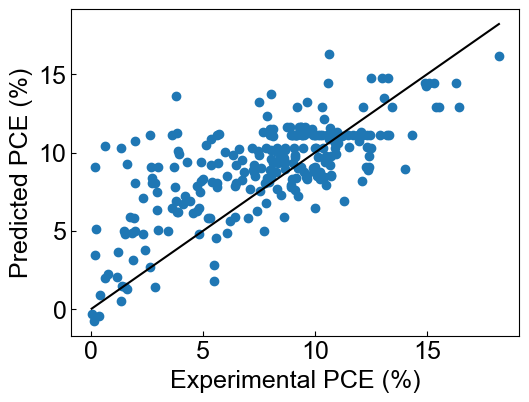

In [85]:
plt.rcParams['font.family'] ='Arial'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
y_test_pred_array = np.array(pd.read_csv("y_test_pred_NN_ErG.csv"))
y_test_real_array = np.array(y_test).reshape(len(y_test),1)
df = pd.DataFrame(np.concatenate([y_test_pred_array,y_test_real_array],axis=1),
             columns = ["Predicted PCE (%)", "Experimental PCE (%)"])
plt.scatter(y_test_real_array,y_test_pred_array)
plt.xlabel("Experimental PCE (%)")
plt.ylabel("Predicted PCE (%)")
plt.plot([y_test_real_array.min(), y_test_real_array.max()], [y_test_real_array.min(), y_test_real_array.max()], c="black")

In [104]:
plt.rcParams['font.family'] ='Arial'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
for model in ["NN", "RF", "GB"]:
    for disc in ["ErG", "ECFP", "Estate", "MACCSKeys"]:
        y_test_pred_array = np.array(pd.read_csv(f"y_test_pred_{model}_{disc}.csv"))
        y_test_real_array = np.array(y_test).reshape(len(y_test),1)
        plt.scatter(y_test_real_array,y_test_pred_array, c= "orange")
        plt.xlabel("Experimental PCE (%)")
        plt.ylabel("Predicted PCE (%)")
        plt.plot([y_test_real_array.min(), y_test_real_array.max()],
                 [y_test_real_array.min(), y_test_real_array.max()], c="black")
        plt.savefig(f"y_test_pred_{model}_{disc}.png", dpi=300)
        plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
def jointplot(use_X, model, split, prop, fill, rs):
    train = pd.read_csv(f"y_train_pred_{model}_{disc}.csv")
    test = pd.read_csv(f"y_test_pred_{model}_{disc}.csv")
    train[" "] = "train"
    train.rename(columns = {'y_train_real': 'Experimental PCE (%)','y_train_pred': 'Predicted PCE (%)'},
                inplace = True)
    test[" "] = "test"
    test.rename(columns = {'y_test_real': 'Experimental PCE (%)','y_test_pred': 'Predicted PCE (%)'},
                inplace = True)
    stack = pd.concat([train,test]).reset_index()
    plt.rcParams['font.family'] ='Arial'#使用するフォント
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 18 #フォントの大きさ
    fig = sns.jointplot(x=stack["Experimental PCE (%)"], y=stack["Predicted PCE (%)"], hue=stack[" "],joint_kws={'alpha': 0.3},edgecolor='white')
    handles, labels = fig.ax_joint.get_legend_handles_labels()
    fig.ax_joint.legend(handles, labels)
    plt.plot([stack["Experimental PCE (%)"].min(), stack["Experimental PCE (%)"].max()], [stack["Experimental PCE (%)"].min(), stack["Experimental PCE (%)"].max()], c="black")
    plt.locator_params(axis='x',nbins=10)
    plt.locator_params(axis='y',nbins=10)
    plt.xlim([stack["Experimental PCE (%)"].min()-2, stack["Experimental PCE (%)"].max()+2])
    plt.ylim([stack["Experimental PCE (%)"].min()-2, stack["Experimental PCE (%)"].max()+2])
    plt.savefig(f"data/model/regression result save folder/jointplot_{use_X}_{model}_{split}_{prop}_{fill}_r{rs}.png", dpi=300)

In [33]:
y = df["PCE_ave(%)"]

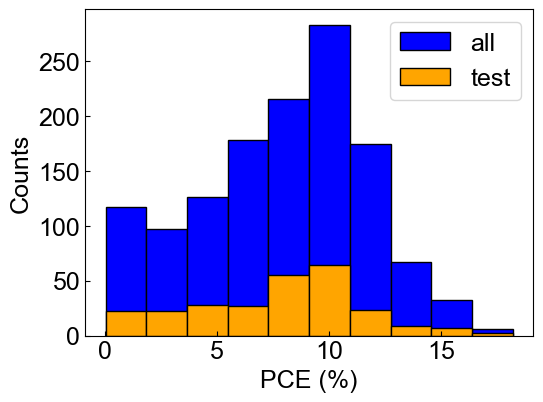

In [106]:
plt.hist(y,bins = 10, ec="black",label="all", color="blue")
plt.hist(y_test, bins=10, ec="black", label="test", color= "orange")
plt.xlabel("PCE (%)")
plt.ylabel("Counts")
plt.legend()
plt.savefig("opvhist.png", dpi=300)

In [107]:
y.describe()

count    1295.000000
mean        7.899969
std         3.810521
min         0.010000
25%         5.290000
50%         8.400000
75%        10.655000
max        18.220000
Name: PCE_ave(%), dtype: float64

In [109]:
y_test.describe()

count    259.000000
mean       7.764710
std        3.759581
min        0.010000
25%        4.940000
50%        8.350000
75%       10.265000
max       18.220000
Name: PCE_ave(%), dtype: float64

In [111]:
rf_estate = RandomForestRegressor(n_estimators = 500)
rf_estate.fit(X_Estate,y)

RandomForestRegressor(n_estimators=500)

In [115]:
fti = rf_estate.feature_importances_

In [118]:
len(fti)

158

In [122]:
print("n_Estate", sum(fti[0:79]))
print("p_Estate", sum(fti[79:158]))

n_Estate 0.6959096836614637
p_Estate 0.3040903163385362


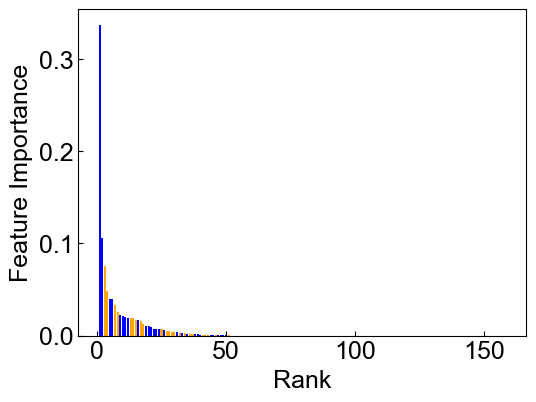

In [160]:
data = fti
half_index = len(data) // 2
sorted_data = sorted(data, reverse=True)
sorted_indices = sorted(range(len(data)), key=lambda x: data[x], reverse=True)

colors = ['b'] * half_index + ['orange'] * (len(data) - half_index)
sorted_colors = [colors[i] for i in sorted_indices]

ranks = range(1, len(sorted_data) + 1)

plt.bar(ranks, sorted_data, color=sorted_colors)
plt.xlabel('Rank')
plt.ylabel('Feature Importance')
plt.savefig("estate_fti_rank.png")

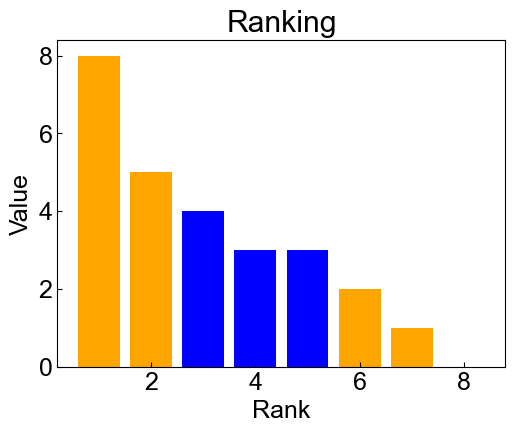

In [140]:
data = [3, 3, 0, 4, 5, 1, 8, 2]

half_index = len(data) // 2
sorted_data = sorted(data, reverse=True)
sorted_indices = sorted(range(len(data)), key=lambda x: data[x], reverse=True)

colors = ['b'] * half_index + ['orange'] * (len(data) - half_index)
sorted_colors = [colors[i] for i in sorted_indices]

ranks = range(1, len(sorted_data) + 1)

plt.bar(ranks, sorted_data, color=sorted_colors)
plt.xlabel('Rank')
plt.ylabel('Value')
plt.title('Ranking')
plt.show()

In [147]:
fti[25]

0.33679809491931595

In [156]:
est = X_Estate.T[25]

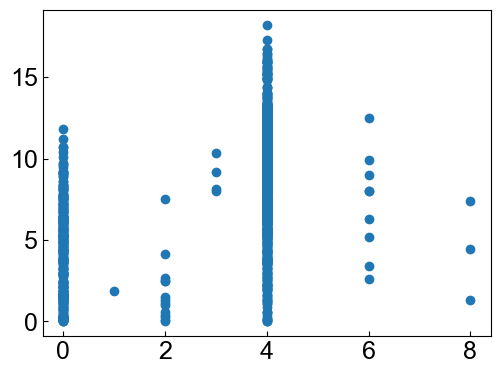

In [157]:
plt.scatter(est, y)

In [159]:
np.shape(n_MACCSKeys)

(1295, 167)